In [1]:
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [2]:
import fiona; #help(fiona.open)

In [3]:
%load_ext autoreload

In [32]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

## Accessing OBIS data

Obis data contains species information and points of observation

In [5]:
from pyobis import occurrences

In [7]:
# MPA file
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [8]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

query = occurrences.search(geometry=geometry)
query.execute()

# Returns the data
df2 = query.data 

Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4216/4216
Fetched 4216 records.


In [10]:
# convert OBIS dataframe to geodataframe
# making point with the lat and lon information
df2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.decimalLongitude, df2.decimalLatitude))

## Calculation of each modulation factor separately

General settings that are needed for all modulating factors

In [11]:
# Making a grid geoDataFrame
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=1.)

In [13]:
MF1 = mbu_biodiversity_score(ACMC, df2, grid, 'OBIS', 31970)

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
MF1.head()

,Grid_ID,shannon,geometry,area_sqkm,simpson,mbu_biodiversity_score
0,0,NaN,"POLYGON ((-88.32201 2.15063, -88.82201 3.01666...",31986.471199,NaN,NaN
1,1,1.879731,"POLYGON ((-88.32201 3.88268, -88.82201 4.74871...",31936.727495,10.825138,12017.475862
2,2,1.932157,"POLYGON ((-88.32201 5.61474, -88.82201 6.48076...",31858.465100,23.733809,12772.136942
3,3,NaN,"POLYGON ((-88.32201 7.34679, -88.82201 8.21281...",31751.740608,NaN,NaN
4,4,NaN,"POLYGON ((-86.82201 1.28461, -87.32201 2.15063...",31954.393897,NaN,NaN


<AxesSubplot:>

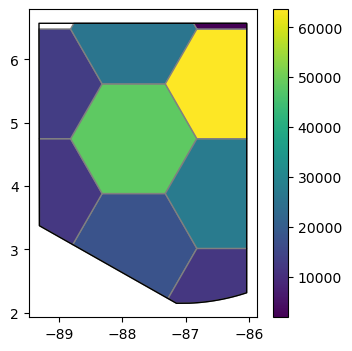

In [15]:
MF1 = gpd.clip(MF1.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = MF1.plot(column='mbu_biodiversity_score', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')

In [16]:
MF2 = mbu_species_richness(ACMC, df2, grid, 31970)

In [17]:
MF2.head()

,geometry,Grid_ID,species_richness,area_sqkm,mbu_species_richness
0,"POLYGON ((-88.32201 2.15063, -88.82201 3.01666...",0,1,31986.471199,11.064155
1,"POLYGON ((-88.32201 3.88268, -88.82201 4.74871...",1,18,31936.727495,198.845069
2,"POLYGON ((-88.32201 5.61474, -88.82201 6.48076...",2,43,31858.465100,473.854721
3,"POLYGON ((-88.32201 7.34679, -88.82201 8.21281...",3,1,31751.740608,10.982961
4,"POLYGON ((-86.82201 1.28461, -87.32201 2.15063...",4,1,31954.393897,11.053059


<AxesSubplot:>

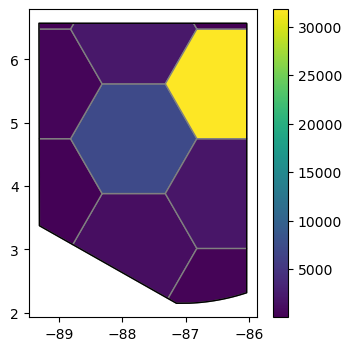

In [18]:
MF2 = gpd.clip(MF2.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = MF2.plot(column='mbu_species_richness', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')

In [19]:
MF3 = mbu_endemism(ACMC, df2, grid, 'OBIS', 31970)

Endemic Modulating Factor is not available to OBIS data


UnboundLocalError: local variable 'df1' referenced before assignment

In [20]:
MF4 = mbu_wege(ACMC, df2, grid, 'OBIS', 31970)

WEGE Modulating Factor is not available to OBIS data


UnboundLocalError: local variable 'df1' referenced before assignment

Habitats survey require a list of paths where the EFG files are.

In [21]:
# locally
source_dir = '/Users/maureenfonseca/Desktop/Data-Oceans/Ecosystem_Typology_IUCN/'
eco_names = np.sort(glob.glob(source_dir + "/*.json"))

In [22]:
MF5 = mbu_habitats_survey(ACMC, grid, eco_names, 31970)

/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:143: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:164: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


## Calculation of a total number of MBUs from all MFs

Let's choose which MF to calculate:

In [30]:
# Modulating factors list
MF = ['biodiversity_score', 'species_richness', 'endemism', 'wege', 'habitats_survey']

In [36]:
test = give_mbu_score(MF, ACMC, df2, 'hexagon', 1, eco_names, 'OBIS', 31970)

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:143: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/oceanprogram/Experimental_Work/MBU_utils.py:164: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


<AxesSubplot:>

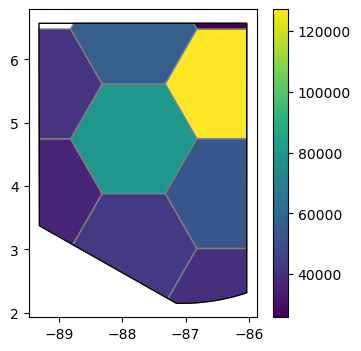

In [37]:
test = gpd.clip(test.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = test.plot(column='Total_MBUs', figsize=(4, 4), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')